In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import warnings

import scipy
from scipy.spatial import distance_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm import tqdm

from visuals import *
from my_lib import *

In [2]:
def HankelMatrix(qwe, L):  
    N = qwe.shape[0]
    return scipy.linalg.hankel(qwe[ : N - L + 1], qwe[N - L : N])

def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

In [3]:
class NWregression():

    def __init__(self, p, h, kernel = 'gaussian'):
        kernels = {
            'gaussian': self._gaussian_kernel,
            'rectangular': self._rectangular_kernel,
            'triangular': self._triangular_kernel,
            'quadratic': self._quadratic_kernel,
            'quartic': self._quartic_kernel
        }
        self.p = p
        self.h = h
        self.kernel = kernels[kernel]
        
    def _gaussian_kernel(self, r):
        return np.exp(-2*r**2)
    
    def _rectangular_kernel(self, r):
        return r * (r < 1)

    def _triangular_kernel(self, r):
        return (1-r) * (r < 1)

    def _quadratic_kernel(self, r):
        return (1-r**2) * (r < 1)

    def _quartic_kernel(self, r):
        return (1-r**2)**2 * (r < 1)
    
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        return self

    def predict(self, X):
        
        dist_matrix = distance_matrix(X,self.X, p = self.p)
        
        weight = self.kernel(dist_matrix/self.h)
        
        norm_coef = np.sum(weight,axis=1).reshape((len(X),1))
        
        regression_ans = (weight@self.Y)/norm_coef
        
        return regression_ans

In [6]:
x_acc_test, t_test = prepare_time_series('./data/30 sec 2_accm.csv')

x_acc, t = prepare_time_series('./data/long_walk_100_acc.csv')

n_steps = 10

dt = 462 * n_steps
x_acc = x_acc[7220:7220+dt]
fig = go.Figure()
fig.add_scatter(y = x_acc[:], mode='lines', name='x_acc')
fig.show()

In [7]:
X_h = HankelMatrix(x_acc,454)

pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

X = np.linspace(0, 2*np.pi * (n_steps - 1), len(X_PCA))%(2*np.pi)
X = X.reshape((len(X),1))
Y = X_PCA
X_mean = np.linspace(0,2*np.pi,900).reshape((900,1))

In [8]:
model = NWregression(p = 2, h = 0.03, kernel = 'quartic')
model.fit(X,Y)
regression = model.predict(X_mean)

In [11]:
fig = go.Figure()
fig.update_layout(autosize=False, width=700, height=700)
fig.add_trace(go.Scatter3d(x=Y[:,0],
                           y=Y[:,1],
                           z=Y[:,2],
                           marker=dict(size=0.1,line=dict(width=0.01)),
                           name = 'X_PCA'
                          )
             )
fig.add_trace(go.Scatter3d(x=regression[:,0],
                           y=regression[:,1],
                           z=regression[:,2],
                           marker=dict(size=0.1,line=dict(width=0.01)),
                           name = 'Mean'
                            )
                )
fig.layout.template = 'plotly_white'
fig.show()

In [18]:
#поворот для отрисовки
Y_ = Y[:,:3]
regression_ = regression[:,:3]
a = -30/180 * np.pi

T_X = np.array([[1,0,0],
                [0,np.cos(a),-np.sin(a)],
                [0,np.sin(a),np.cos(a)]])

T_Y = np.array([[np.cos(a),-np.sin(a),0],
                [np.sin(a),np.cos(a),0],
                [0,0,1]])

T_Z = np.array([[np.cos(a),0,np.sin(a)],
                [0,1,0],
                [-np.sin(a),0,np.cos(a)]])

Y_ = Y_@T_Y
regression_ = regression_@T_Y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(Y_[:,0],
        Y_[:,1],
        Y_[:,2],
        label='Фазовая траектория')

ax.plot(regression_[:,0],
        regression_[:,1],
        regression_[:,2],
        label='Модель',
        lw = 3)

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.view_init(elev=20, azim=135)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
plt.legend()
# fig.savefig('phase.eps',
#             format='eps',
#             dpi=600)
plt.show()

ValueError: Unknown projection '3d'

In [13]:
D_init = np.min(distance_matrix(X_PCA, regression, p = 1),axis = 1).reshape((len(X_PCA),1))
model_D = NWregression(p = 2, h = 0.03)
model_D.fit(X,D_init)
regression_D = model_D.predict(X_mean)

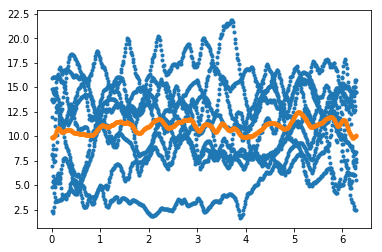

In [17]:
plt.plot(X,D_init,'.')
plt.plot(X_mean,regression_D,'.')
plt.show()

In [16]:
D = np.mean(D_init)
D

10.964237001934977